# Laboratório 2: Mofo e Fungicide

### Referente ao capítulo 6

Nesse laboratório, seja $x(t)$ a concentração de mofo que queremos reduzir em um período de tempo fixo. Assumiremos que $x$ tenha crescimento com taxa $r$ e capacidade de carga $M.$ Seja $u(t)$ o fungicida que reduz a população em $u(t)x(t).$ Assim

$$
x'(t) = r(M - x(t)) - u(t)x(t), x(0) = x_0 > 0
$$

O efeito do mofo e do fungicida são negativos para as pessoas ao redor e, por isso, queremos minimizar ambos. Assim, nosso objetivo será 

$$
\min_u \int_0^T Ax(t)^2 + u(t)^2 dt
$$

tal que $A$ é o parâmetro que balanceia a importância dos termos do funcional. 

**Resultado de existência:** $f(t,x,u) = Ax^2 + u^2 \implies f_{xx}(t,x,u) = 2A, f_{uu}(t,x,u) = 2$, logo $f$ é continuamente diferenciável nas três variáveis e convexa em $x$ e $u$. $g(t,x,u) = r(M - x(t)) - u(t)x(t) \implies g_{xx} = g_{uu} = 0$ e, de mesma forma é continuamente diferenciável e convexa em $x$ e $u$. 

Assim, após encontrarmos $\lambda$ que satisfaça as condições necessárias, temos um resultado de existência, caso a integral seja finita. 

## Condições Necessárias 

### Hamiltoniano

$$
H = Ax^2 + u^2 + \lambda(r(M - x) - ux)
$$

### Condição de otimalidade

$$
0 = H_u = 2u - \lambda x \implies u^{*}(t) = \frac{1}{2}\lambda(t)x(t)
$$

### Equação adjunta 

$$
\lambda '(t) = - H_x = -2Ax(t) + \lambda(t)(r + u(t)) 
$$

### Condição de transversalidade 

$$
\lambda(T) = 0
$$

Observe que formamos um sistema não linear de equações diferenciais, que tornam a solução analítica muito mais complexa. Por isso, vamos resolver esse problema de forma iterativa. 

### Importanto as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

In [2]:
x_sp,u_sp,lambda_sp, r_sp, A_sp, M_sp = sp.symbols('x u lambda r A M') 
H = A_sp*x_sp**2 + u_sp**2 + lambda_sp*(r_sp*(M_sp - x_sp) - u_sp*x_sp)

Com a biblioteca `sympy` é possível obter as condições necessárias sem fazer contas. 

In [3]:
print('H_x = {}'.format(sp.diff(H,x_sp)))
print('H_u = {}'.format(sp.diff(H,u_sp)))
print('H_lambda = {}'.format(sp.diff(H,lambda_sp)))

H_x = 2*A*x + lambda*(-r - u)
H_u = -lambda*x + 2*u
H_lambda = r*(M - x) - u*x


Podemos resolver a equação $H_u = 0$, mas esse passo é importante conferir manualmente também.

In [4]:
eq = sp.Eq(sp.diff(H,u_sp), 0)
sp.solve(eq,u_sp)

[lambda*x/2]

Dessa vez vamos utilizar uma classe escrita em Python que codifica o algoritmo apresentado no Capítulo 5 e no Laboratório 1. 

Primeiro precisamos definir as equações importantes das condições necessárias. É importante escrever no formato descrito nesse notebook. `par` é um dicionário com os parâmetros específicos do modelo. 

In [5]:
parameters = {'r': None, 'M': None, 'A': None}

diff_state = lambda t, x, u, par: par['r']*(par['M'] - x) - u*x                    # Derivada de x
diff_lambda = lambda t, x, u, lambda_, par: -2*par['A']*x + lambda_*(par['r'] + u) # Derivada de lambda_
update_u = lambda t, x, lambda_, par: 0.5*lambda_*x                                # Atualiza u através de H_u = 0

## Aplicando a classe ao exemplo 

Vamos fazer algumas exeperimentações. Sinta-se livre para variar os parâmetros.

In [6]:
problem = OptimalControl(diff_state, diff_lambda, update_u)

In [7]:
x0 = 1
T = 5
parameters['r'] = 0.3
parameters['M'] = 10
parameters['A'] = 1

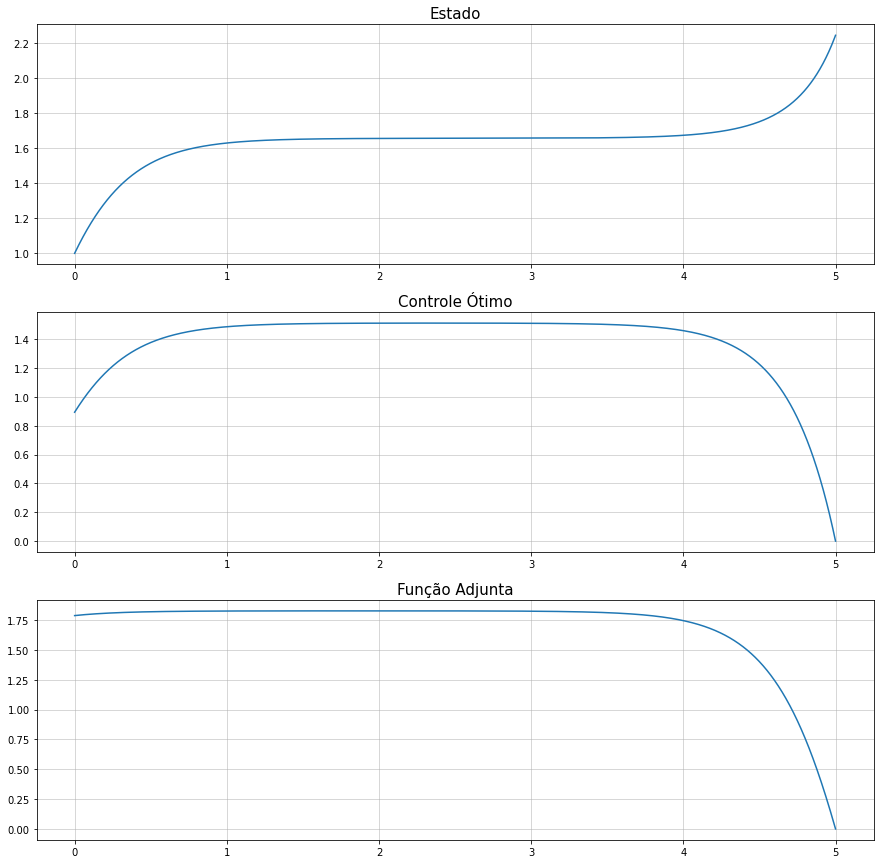

In [8]:
t,x,u,lambda_ = problem.solve(x0, T, parameters, h = 0.001)
problem.plotting(t,x,u,lambda_)

O controle inicialmente aumenta até atingir um valor constante, da mesma forma que o estado. Dizemos que eles estão em equilíbrio. Eventualmente o controle decresce a 0. Note que o estado não decresce e isso acontece pela ponderação equivalente que damos aos efeitos negativo do mofo e do fungicida. Por isso, podemos sugerir um aumento em $A$. 

In [9]:
parameters['A'] = 10

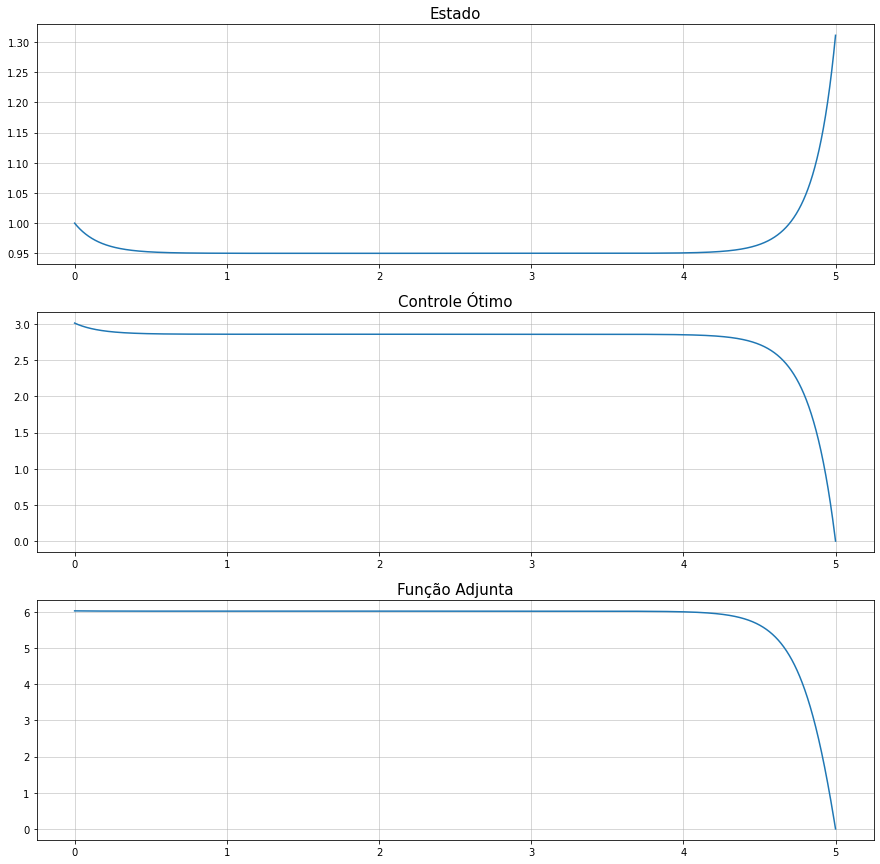

In [10]:
t,x,u,lambda_ = problem.solve(x0, T, parameters, h = 0.001)
problem.plotting(t,x,u,lambda_)

Aqui o uso de fungicida é muito maior. Como gostaríamos, a quantidade de mofo também é menor em sua constante, porém no final do intervalo, quando a quantidade do fungicida diminui, o nível de mofo cresce consideravelmente. Para fins de comparação, podemos visualizar a diferença de quando $u \equiv 0$ do controle ótimo. Para isso, temos que fazer a integração da derivada de $x$ no intervalo. 

In [11]:
integration = solve_ivp(fun = diff_state, 
                        t_span = (0,T), 
                        y0 = (x0,), 
                        t_eval = np.linspace(0,T,len(u)), 
                        args = (0,parameters))

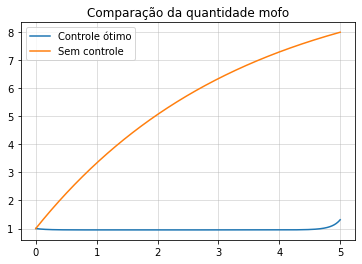

In [12]:
plt.plot(t, x, integration.t, integration.y[0])
plt.title('Comparação da quantidade mofo')
plt.legend(['Controle ótimo', 'Sem controle'])
plt.grid(alpha = 0.5)

## Experimentação 

Descomente a célula a seguir e varie os parâmetros para ver seus efeitos: 

1. Aumentar $r$ para ver o crescimento mais rápido do mofo. Como o controle vai se comportar?
2. Variar $T$ faz alguma diferença? Como é essa diferença? 
3. Variar $M$, a capacidade de carga, gera que efeito no estado? 

In [13]:
#x0 = 1
#T = 5
#parameters['r'] = 0.3
#parameters['M'] = 10
#parameters['A'] = 1
#
#t,x,u,lambda_ = problem.solve(x0, T, parameters, h = 0.001)
#roblem.plotting(t,x,u,lambda_)